In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from pylab import rcParams
from keras.models import Model, load_model
#from keras.layers import Input, Dense
from tensorflow.keras.layers import Input, Dense
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.





# Preprocessing

In [2]:
df = pd.read_csv('./DataP2/cleaned.csv')

In [3]:
print(df.shape)
df.head()

(9622407, 98)


,Unnamed: 0,Unnamed: 0.1,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,...,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw,days_before_failure
0,0,0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,135.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0
1,1,1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0
2,2,2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0
3,3,3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0
4,4,4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0


In [11]:
"""le = LabelEncoder()
encoded = le.fit_transform(df['model'])
le.inverse_transform(encoded)"""

array(['Hitachi HDS5C3030ALA630', 'Hitachi HDS5C3030ALA630',
       'Hitachi HDS5C4040ALE630', ..., 'Hitachi HDS5C3030ALA630',
       'ST4000DM000', 'ST4000DM000'], dtype=object)

In [4]:
# Constants
RANDOM_SEED = 314
TEST_PCT = 0.2

In [5]:
df_norm = df

# Drop the following columns
#df_norm.drop(['date', 'model', 'serial_number', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df_norm.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

# Drop normalized columns
df_norm = df_norm[df_norm.columns.drop(list(df_norm.filter(regex='normalized')))]

# Drop Duplicate Rows
df_norm = df_norm.drop_duplicates(subset=None, keep='first', inplace=False).reset_index(drop=True)

# Drop Columns where all entries are NAN
df_norm.dropna(axis=1, how='all', inplace=True)

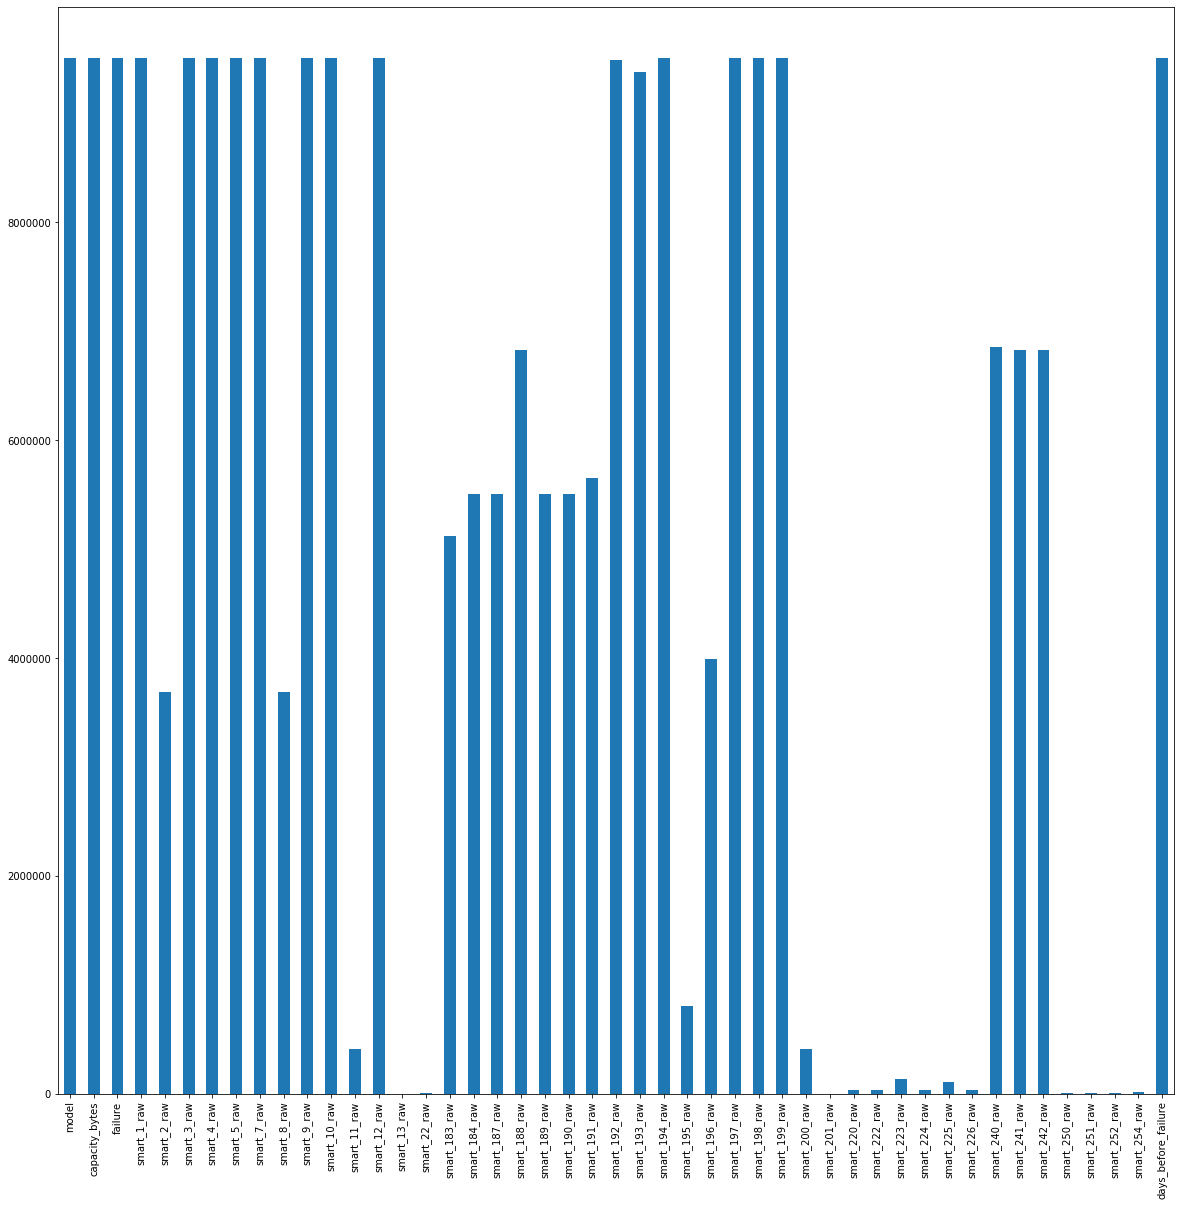

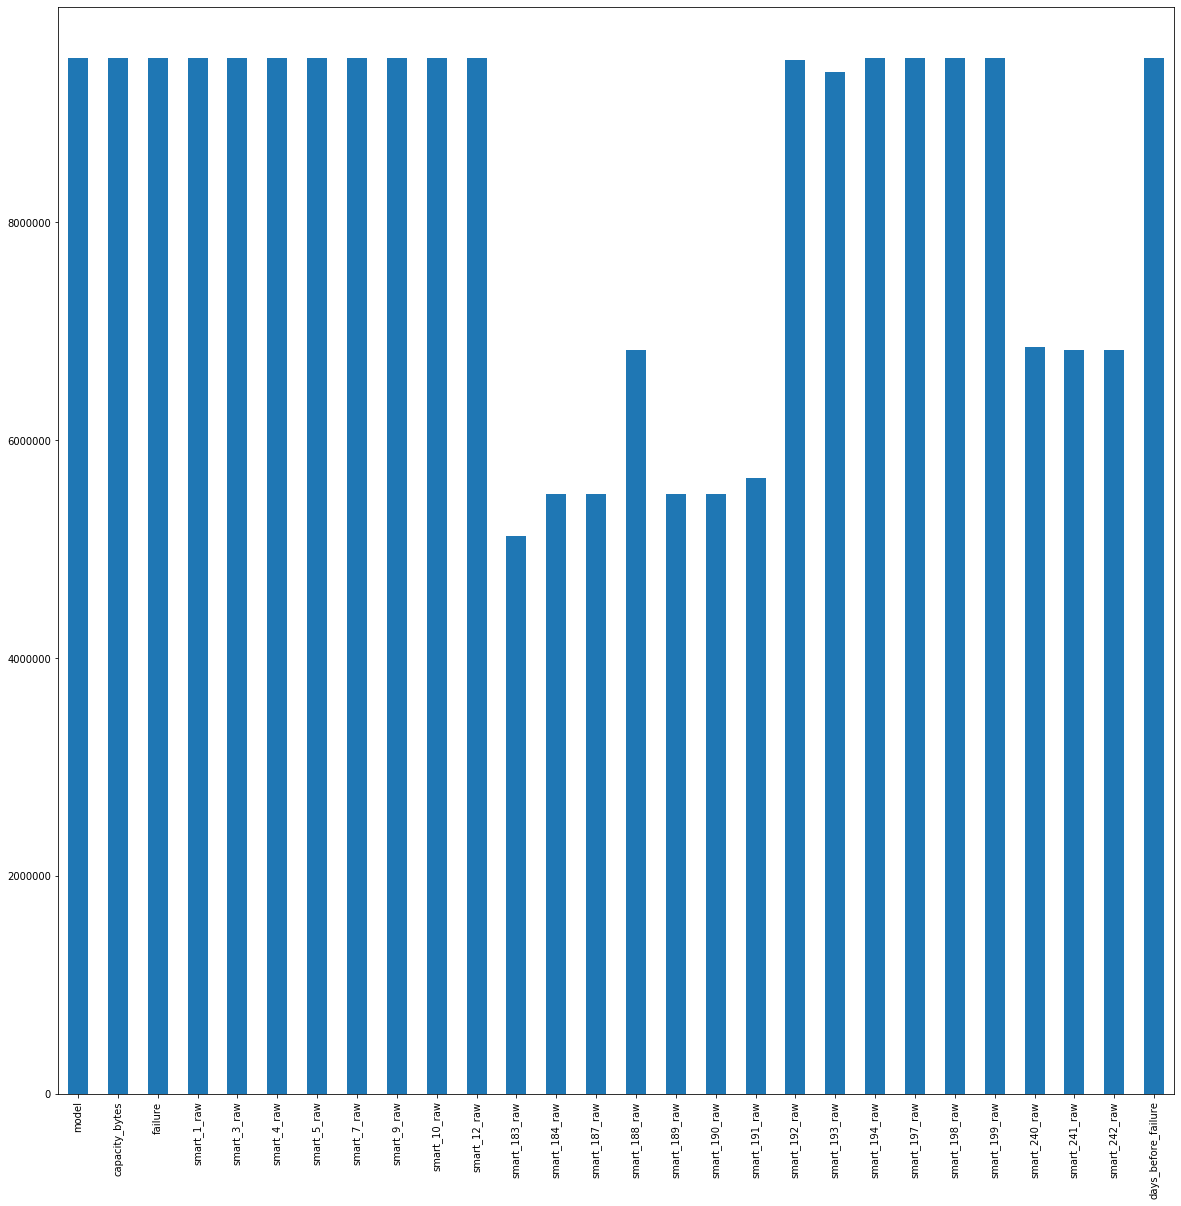

In [ ]:
# Plot Column Counts
df_norm.count()[2:].plot(kind='bar', figsize=(20,20))
#plt.savefig('ColumnsCountBefore.png')
plt.show()

# Drop All columns with count less than 5M
df_norm.drop(['smart_2_raw', 'smart_8_raw', 'smart_11_raw', 'smart_13_raw', 
              'smart_22_raw','smart_195_raw','smart_196_raw', 'smart_200_raw',
             'smart_201_raw','smart_220_raw','smart_222_raw', 'smart_223_raw',
              'smart_224_raw','smart_225_raw','smart_226_raw','smart_250_raw',
              'smart_251_raw','smart_252_raw','smart_254_raw'], axis=1, inplace=True)

# Plot New Column Counts
df_norm.count()[2:].plot(kind='bar', figsize=(20,20))
#plt.savefig('ColumnsCountAfter.png')
plt.show()

# Replace NaNs with mean
df_norm.fillna(df_norm.mean(), inplace=True)

display(df_norm.head())
df_norm.shape

In [ ]:
df_norm.to_csv('./DataP2/preprocessed.csv')





#                                           Machine Learning

In [8]:
# Split
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)

# Transform to DF
trainDf = pd.DataFrame(train_x)
trainDf.columns = df_norm.columns

testDf = pd.DataFrame(test_x)
testDf.columns = df_norm.columns

# Training Data
train_x = trainDf[trainDf.days_before_failure >= 200] # Healthy drives
train_x = train_x.drop(['failure', 'days_before_failure'], axis=1) # drop the Failure, days_before_failure column

# Testing Data
test_y = testDf['failure']
test_x = testDf.drop(['failure'], axis=1) #drop the failure column

display(train_x.head())
display(test_x.head())
display(test_y.head())

# Scale and Standardize & Transform DF to ndarray
train_x = StandardScaler().fit_transform(train_x)
test_x = StandardScaler().fit_transform(test_x)
test_y = test_y.values

print(train_x)
print(test_x)

,capacity_bytes,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_12_raw,...,smart_191_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,1.482490e-311,0,0,540,14,0,0.000000e+00,27929,0,14,...,721.82753,216.0,216.0,20.0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00
1,1.976651e-311,0,54551400,0,4,0,1.279800e-317,411,0,4,...,0.00000,0.0,16090.0,30.0,0,0,0,1.319155e-321,3.467963e-315,1.316882e-315
2,1.482490e-311,0,0,566,19,0,0.000000e+00,27492,0,18,...,721.82753,213.0,213.0,24.0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00
3,1.482490e-311,0,0,507,15,0,0.000000e+00,26640,0,15,...,721.82753,241.0,241.0,31.0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00
4,1.482490e-311,0,0,6250,10,0,0.000000e+00,12198,0,10,...,721.82753,3.0,361.0,29.0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00


,capacity_bytes,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_12_raw,smart_183_raw,...,smart_191_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
1759233,1.976651e-311,208786832,0,1,0,1.221463e-315,6782,0,1,0.000000,...,0.00000,0.0,30366.0,36.0,0,0,0,3.214391e-320,1.212084e-313,3.273992e-314
1272381,1.976651e-311,153923480,0,2,0,1.315462e-315,7737,0,2,0.000000,...,0.00000,0.0,36130.0,27.0,0,0,0,3.754405e-320,1.285532e-313,2.116224e-314
9345586,1.976651e-311,83539592,0,3,0,3.915898e+08,9439,0,3,0.000000,...,0.00000,0.0,11636.0,31.0,0,0,0,9.188000e+03,3.266810e+10,6.894061e+09
1917615,1.976651e-311,61243168,0,2,0,6.777619e-316,3821,0,2,0.000000,...,0.00000,0.0,12648.0,23.0,0,0,0,1.817668e-320,7.758671e-314,8.041525e-315
6466407,1.976651e-311,0,0,4,0,0.000000e+00,19638,0,4,4.244463,...,721.82753,271.0,271.0,22.0,0,0,0,1.099766e+13,1.342085e+10,4.409590e+10


,capacity_bytes,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_12_raw,smart_183_raw,...,smart_191_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
256338,1.976651e-311,14588680,0,15,0,3.512602e-315,10707,0,15,0.000000,...,0.00000,7.0,24382.0,20.0,0,0,0,5.245495e-320,9.781328e-314,9.557874e-313
8715101,1.976651e-311,134381384,0,4,0,4.388257e+08,11863,0,4,0.000000,...,0.00000,0.0,35957.0,20.0,0,0,0,1.171600e+04,3.559665e+10,8.307753e+09
7637951,1.482490e-311,0,555,13,212,0.000000e+00,32188,0,13,4.244463,...,721.82753,361.0,361.0,22.0,0,0,0,1.099766e+13,1.342085e+10,4.409590e+10
1108539,1.482490e-311,0,565,27,0,0.000000e+00,38242,0,27,4.244463,...,721.82753,1430.0,1430.0,29.0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00
4943692,1.976651e-311,0,554,12,0,0.000000e+00,17453,0,12,4.244463,...,721.82753,301.0,301.0,30.0,0,0,0,1.099766e+13,1.342085e+10,4.409590e+10


256338     0
8715101    0
7637951    0
1108539    0
4943692    0
Name: failure, dtype: int64

[[ 1.42838893e-313  1.71126431e+000 -3.22854970e-001 ... -2.92292468e-001
  -1.16998314e+000 -1.42007490e-001]
 [ 1.42838893e-313  1.02957856e+000 -3.22854970e-001 ... -2.92292468e-001
  -1.16998314e+000 -1.42007490e-001]
 [ 1.42838893e-313  1.55047709e-001 -3.22854970e-001 ... -2.92292468e-001
   1.67805788e+000 -1.19830325e-001]
 ...
 [ 1.42838893e-313 -8.82944825e-001  6.95698314e+000 ...  1.58715791e-004
   6.17206264e-005 -1.57555553e-004]
 [-9.74039147e-312 -8.82944825e-001  2.66394222e-001 ...  1.58715791e-004
   6.17206264e-005 -1.57555553e-004]
 [ 1.42838893e-313 -6.32883872e-001 -3.22854970e-001 ... -2.92292468e-001
   1.01698131e+000  2.52785466e-001]]
[[ 1.35695393e-313 -7.01885620e-001 -3.22781463e-001 ... -2.92451842e-001
  -1.17024138e+000 -1.45477553e-001]
 [ 1.35695393e-313  7.86260352e-001 -3.22781463e-001 ... -2.92451842e-001
   1.93297995e+000 -1.17946987e-001]
 [-4.80591979e-312 -8.83116068e-001  1.96486019e-001 ... -6.33489388e-004
  -2.46871882e-004  6.49223712e-

In [9]:
train_x.shape[1]

25

In [18]:
# AutoEncoder

# Parameters
nb_epoch = 200
batch_size = 50000
# Network 25 -> 20 -> 12 -> 5    -> 12 -> 20 -> 25
input_dim = train_x.shape[1] #num of columns 25
encoding_dim = 21
hidden_dim1 = 13
hidden_dim2 = 4
learning_rate = 1e-7 # 1e-7

# Encoder
input_layer = keras.Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="relu")(encoder)
encoder = Dense(hidden_dim2, activation="relu")(encoder) #

# Decoder
decoder = Dense(hidden_dim2, activation='relu')(encoder)
decoder = Dense(hidden_dim1, activation='relu')(decoder) #
decoder = Dense(input_dim, activation='relu')(decoder) 

# Model
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

In [19]:
# Train Model

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

#cp = keras.callbacks.ModelCheckpoint(filepath="autoencoder.h5",
#                               save_best_only=True,
#                               verbose=0)
#logdir = os.path.join('logs')
#tb = keras.callbacks.TensorBoard(log_dir=logdir,
#                histogram_freq=0,
#                write_graph=True,
#                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1, #callbacks=[cp, tb]
                    ).history

Train on 7501972 samples, validate on 1875493 samples
Epoch 1/200
7501972/7501972 [==============================] - 5s 1us/sample - loss: 0.9222 - accuracy: 0.1915 - val_loss: 0.8869 - val_accuracy: 0.2807
Epoch 2/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.8596 - accuracy: 0.2991 - val_loss: 0.8261 - val_accuracy: 0.3930
Epoch 3/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.7754 - accuracy: 0.4818 - val_loss: 0.7173 - val_accuracy: 0.5684
Epoch 4/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.6705 - accuracy: 0.6679 - val_loss: 0.6258 - val_accuracy: 0.7234
Epoch 5/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.5806 - accuracy: 0.7322 - val_loss: 0.5572 - val_accuracy: 0.7510
Epoch 6/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.5513 - accuracy: 0.7591 - val_loss: 0.5487 - val_accuracy: 0.7604
Epoch 7/200
7501972/7501972 

Epoch 54/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.4682 - accuracy: 0.8139 - val_loss: 0.4631 - val_accuracy: 0.8180
Epoch 55/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.4620 - accuracy: 0.8219 - val_loss: 0.4633 - val_accuracy: 0.8194
Epoch 56/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.4642 - accuracy: 0.8146 - val_loss: 0.4633 - val_accuracy: 0.8154
Epoch 57/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.4621 - accuracy: 0.8205 - val_loss: 0.4631 - val_accuracy: 0.8199
Epoch 58/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.4631 - accuracy: 0.8203 - val_loss: 0.4627 - val_accuracy: 0.8200
Epoch 59/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.4617 - accuracy: 0.8226 - val_loss: 0.4620 - val_accuracy: 0.8213
Epoch 60/200
7501972/7501972 [==============================] - 3s 0us/sampl

7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.4621 - accuracy: 0.8422 - val_loss: 0.4610 - val_accuracy: 0.8435- accura
Epoch 160/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.4608 - accuracy: 0.8451 - val_loss: 0.4610 - val_accuracy: 0.8444
Epoch 161/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.4606 - accuracy: 0.8462 - val_loss: 0.4610 - val_accuracy: 0.8440
Epoch 162/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.4605 - accuracy: 0.8464 - val_loss: 0.4609 - val_accuracy: 0.8437
Epoch 163/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.4606 - accuracy: 0.8439 - val_loss: 0.4615 - val_accuracy: 0.8421
Epoch 164/200
7501972/7501972 [==============================] - 3s 0us/sample - loss: 0.4617 - accuracy: 0.8420 - val_loss: 0.4621 - val_accuracy: 0.8437
Epoch 165/200
7501972/7501972 [==============================] - 3s 0us/samp

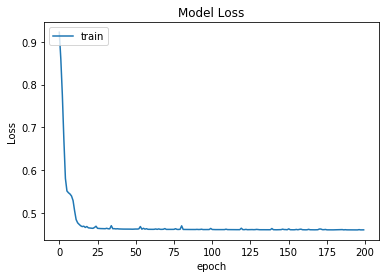

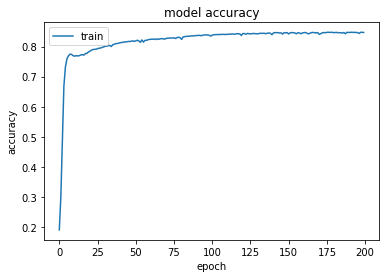

In [35]:
# Model Loss
plt.plot(history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.savefig('ModelLossAE3.png')
plt.show()

# Model Loss
plt.plot(history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('ModelAccuracyAE3.png')
plt.show()

In [21]:
# Save Model

# serialize model to JSON
model_json = autoencoder.to_json()
with open("autoencoderModel3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights("autoencoder3.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
# Load Model

# load json and create model
json_file = open('autoencoderModel3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("autoencoder3.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


pred = loaded_model.predict(test_x)
mse = np.mean(np.power(test_x - pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.head()

Loaded model from disk


,Reconstruction_error,True_class
0,0.245606,0
1,0.169572,0
2,0.111510,0
3,0.402270,0
4,0.038530,0


Healthy MSE = 0.677352756970273
Unhealthy MSE = 5.644948949342849


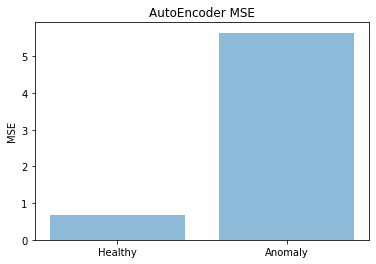

In [36]:
# Metrics
healthy_test = test_x[np.where(test_y == 0)]
anomaly_test = test_x[np.where(test_y == 1)]

pred_healthy = loaded_model.predict(healthy_test)
pred_anomaly = loaded_model.predict(anomaly_test)

mse_healthy = np.sqrt(metrics.mean_squared_error(pred_healthy, healthy_test))
mse_anomaly = np.sqrt(metrics.mean_squared_error(pred_anomaly, anomaly_test))

print(f'Healthy MSE = {mse_healthy}')
print(f'Unhealthy MSE = {mse_anomaly}')

# Plot Healthy MSE vs Anomaly MSE
y_pos = np.arange(len([mse_healthy, mse_anomaly]))
plt.bar(y_pos, [mse_healthy, mse_anomaly], align='center', alpha=0.5)
plt.xticks(y_pos, ['Healthy', 'Anomaly'])
plt.ylabel('MSE')
plt.title('AutoEncoder MSE')
plt.savefig('MSE_AE2.png')
plt.show()


In [29]:
failures_score = error_df.iloc[np.where(test_y == 1)]
healthy_score = error_df.iloc[np.where(test_y == 0)]

failures_score_norm = failures_score
healthy_score_norm = healthy_score

#failures_score_norm['Reconstruction_error'] = StandardScaler().fit_transform(failures_score[['Reconstruction_error']])
#healthy_score_norm['Reconstruction_error'] = StandardScaler().fit_transform(healthy_score[['Reconstruction_error']])


display(failures_score.describe())
display(healthy_score.describe())

,Reconstruction_error,True_class
count,114.000000,114.0
mean,31.865449,1.0
std,230.184188,0.0
min,0.028022,1.0
25%,0.118759,1.0
50%,0.316101,1.0
75%,2.015663,1.0
max,2334.238107,1.0


,Reconstruction_error,True_class
count,1.875379e+06,1875379.0
mean,4.588068e-01,0.0
std,5.963008e+01,0.0
min,3.099268e-03,0.0
25%,5.192343e-02,0.0
50%,9.548201e-02,0.0
75%,1.427972e-01,0.0
max,7.498873e+04,0.0


In [32]:
print(healthy_score.count())
healthy_score[(healthy_score['Reconstruction_error'] >= 0)
                   & (healthy_score['Reconstruction_error'] <= 0.54589)].count()

Reconstruction_error    1875379
True_class              1875379
dtype: int64


Reconstruction_error    1862263
True_class              1862263
dtype: int64

In [33]:
print(failures_score.count())
failures_score[(failures_score['Reconstruction_error'] >= 0)
                   & (failures_score['Reconstruction_error'] <= 0.54589)].count()

Reconstruction_error    114
True_class              114
dtype: int64


Reconstruction_error    65
True_class              65
dtype: int64